In [64]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd

In [29]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [65]:
df1 = read_csv('merge_oil.csv', header=0, index_col=0)
df1.index = pd.to_datetime(df1["Date"],format="%Y-%m-%d")
df1 = df1[["Price","US_Price","Dollar_eq","Open","High","Low","Volume","Percent_Change"]]

df1 = df1.iloc[::-1]
print(df1.head())
values = df1.values

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
#print(reframed.head())
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

             Price  US_Price  Dollar_eq    Open    High     Low    Volume  \
Date                                                                        
2011-12-12  5203.0     97.77     52.605  5180.0  5222.0  5161.0  220040.0   
2011-12-13  5342.0    100.14     53.100  5206.0  5380.0  5206.0  214520.0   
2011-12-14  5209.0     94.95     53.610  5353.0  5368.0  5186.0  243960.0   
2011-12-15  5036.0     93.87     53.520  5200.0  5200.0  5021.0  225330.0   
2011-12-16  4903.0     93.53     52.500  5014.0  5014.0  4877.0  193310.0   

            Percent_Change  
Date                        
2011-12-12           59.80  
2011-12-13            2.67  
2011-12-14           -2.49  
2011-12-15           -3.32  
2011-12-16           -2.64  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.593148   0.848672   0.165767   0.593426   0.564952   0.608853   
2   0.617694   0.876779   0.186307   0.598071   0.591781   0.617017   
3   0.594208   0.815228   0.207469   0.62433

In [67]:
values = reframed.values
#print(values)
split = int(len(list(df1["Price"]))*0.8)
train = values[:split,:]
test = values[split:,:]
train_X,train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(test_y)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1326, 1, 8) (1326,) (331, 1, 8) (331,)


Train on 1326 samples, validate on 331 samples
Epoch 1/50
 - 2s - loss: 0.4139 - val_loss: 0.2075
Epoch 2/50
 - 0s - loss: 0.2432 - val_loss: 0.0739
Epoch 3/50
 - 0s - loss: 0.1642 - val_loss: 0.0570
Epoch 4/50
 - 0s - loss: 0.1085 - val_loss: 0.0815
Epoch 5/50
 - 0s - loss: 0.0738 - val_loss: 0.0379
Epoch 6/50
 - 0s - loss: 0.0598 - val_loss: 0.0305
Epoch 7/50
 - 0s - loss: 0.0365 - val_loss: 0.0187
Epoch 8/50
 - 0s - loss: 0.0253 - val_loss: 0.0125
Epoch 9/50
 - 0s - loss: 0.0296 - val_loss: 0.0109
Epoch 10/50
 - 0s - loss: 0.0234 - val_loss: 0.0173
Epoch 11/50
 - 0s - loss: 0.0183 - val_loss: 0.0139
Epoch 12/50
 - 0s - loss: 0.0184 - val_loss: 0.0125
Epoch 13/50
 - 0s - loss: 0.0292 - val_loss: 0.0110
Epoch 14/50
 - 0s - loss: 0.0178 - val_loss: 0.0178
Epoch 15/50
 - 0s - loss: 0.0188 - val_loss: 0.0219
Epoch 16/50
 - 0s - loss: 0.0205 - val_loss: 0.0111
Epoch 17/50
 - 0s - loss: 0.0174 - val_loss: 0.0166
Epoch 18/50
 - 0s - loss: 0.0322 - val_loss: 0.0186
Epoch 19/50
 - 0s - loss: 

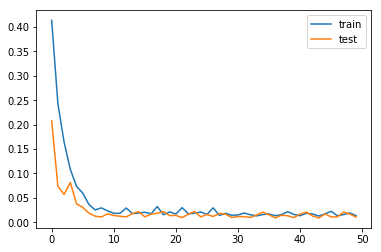

Test RMSE: 78.207


In [68]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

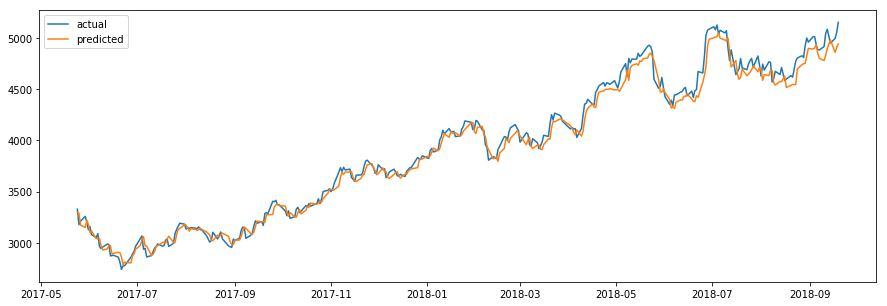

In [69]:
df = read_csv('merge_oil.csv', header=0, index_col=0)
df = df.iloc[::-1]
df.index = pd.to_datetime(df["Date"],format="%Y-%m-%d")

plot_df = pd.DataFrame({'Date':df.iloc[split+1:]["Date"],'Actual':inv_y,'Predicted':inv_yhat})
plot_df.index = pd.to_datetime(plot_df["Date"],format="%Y-%m-%d")

split = int(len(list(df["IOC_Low"]))*0.8)
dates = df.iloc[split+1:]["Date"]

fig = pyplot.figure(figsize=(15,5))

pyplot.plot(plot_df['Actual'],label='actual')
pyplot.plot(plot_df['Predicted'],label='predicted')
#pyplot.xticks(rotation=90)
pyplot.legend()
pyplot.show()

#print(dates)

In [72]:
print(list(inv_y))

[3329.0, 3178.0, 3212.9998, 3259.0, 3202.9998, 3127.0002, 3159.0, 3081.0, 3051.9998, 3090.0, 2966.0, 2945.0, 2958.9998, 2988.0, 2985.0, 2873.0, 2877.0, 2879.0, 2860.9998, 2813.0, 2741.0, 2776.0, 2777.0, 2860.0, 2892.0, 2918.0, 2968.0, 3043.0, 3068.0, 2938.0, 2947.0, 2863.0, 2875.9998, 2912.0, 2948.9998, 2963.9998, 2990.0, 2968.0, 2973.0, 3028.0, 3036.9998, 2965.0, 2997.0, 3090.0, 3132.0002, 3161.0, 3192.0, 3183.0, 3134.9998, 3147.0, 3143.0, 3149.0, 3144.0, 3139.0, 3157.0, 3128.0, 3127.0002, 3070.0, 3008.0, 3021.0, 3104.0, 3038.0, 3072.0002, 3107.0002, 3041.0, 2970.0, 2962.0, 2957.0, 3038.0, 3021.0, 3049.0, 3122.0002, 3154.9998, 3143.0, 3045.0, 3073.0, 3092.0002, 3162.0, 3215.0002, 3191.0, 3207.9998, 3171.0, 3286.0, 3295.0, 3287.0, 3406.0002, 3402.0, 3416.0002, 3373.0, 3373.0, 3310.9998, 3266.0, 3313.0002, 3240.0, 3256.0, 3330.9998, 3347.0, 3296.0, 3310.0, 3363.0, 3353.0, 3385.0, 3359.0, 3383.0, 3431.0002, 3384.0, 3428.0, 3501.0, 3513.0, 3528.0, 3500.0, 3520.0, 3579.0, 3691.0, 3734.0, 3

In [73]:
print(list(inv_yhat))

[3297.464, 3290.3264, 3175.306, 3150.2634, 3219.583, 3179.1465, 3102.3862, 3116.099, 3040.7034, 3043.777, 3043.4294, 2973.803, 2931.5725, 2940.8857, 2975.8848, 2972.0303, 2889.7017, 2897.337, 2909.5413, 2903.5515, 2862.1934, 2787.1018, 2811.6204, 2804.133, 2874.2087, 2893.8801, 2939.048, 2974.8262, 3027.5986, 3061.2366, 2970.3604, 2968.9587, 2876.2292, 2889.0852, 2914.026, 2968.2751, 2972.5745, 3003.1155, 3009.5222, 2998.3738, 3039.714, 3065.2217, 3005.4995, 3003.2812, 3080.8774, 3130.8518, 3140.8767, 3177.7178, 3174.936, 3144.3176, 3114.9702, 3137.1785, 3130.3733, 3122.3013, 3129.148, 3143.6338, 3130.2583, 3106.6643, 3078.0547, 3025.1306, 3021.2437, 3075.9004, 3057.7295, 3077.4382, 3095.3005, 3063.5957, 3008.5574, 2983.279, 2982.8008, 3027.4724, 3028.2375, 3067.9219, 3115.6206, 3155.6848, 3142.062, 3091.7837, 3084.471, 3104.1013, 3159.9631, 3214.126, 3201.04, 3208.826, 3198.4106, 3275.6746, 3273.9739, 3277.6848, 3350.9414, 3367.9988, 3382.141, 3364.2466, 3358.6309, 3296.242, 3259.6257

In [74]:
#OHLC Only